In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt

from src.micrograd import Tensor, TensorMLP

from sklearn.datasets import make_moons, make_blobs

from functools import reduce

%matplotlib inline

In [9]:
seed = 1996
np.random.seed(1996)
random.seed(1996)

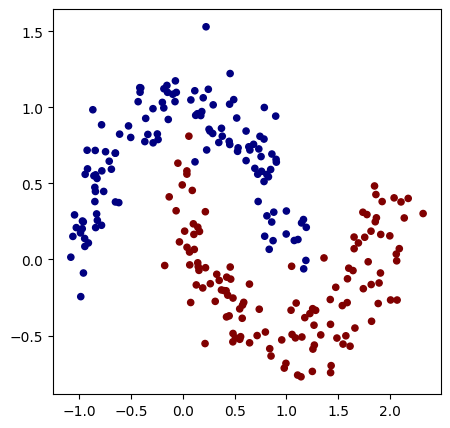

In [10]:
X, y = make_moons(n_samples=250, noise=0.15, random_state=seed)
# X, y = make_blobs(n_samples=250, n_features=2, centers=2, cluster_std=2)
y = y*2 - 1

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

In [11]:
model = TensorMLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2), ReLUTensorNeuron(2)], Layer of [ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16), ReLUTensorNeuron(16)], Layer of [LinearTensorNeuron(16)]]
number of parameters 66


In [12]:
def loss(batch_size=None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    
    inputs = list(map(Tensor, Xb))

    scores = list(map(model, inputs))
    
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    
    alpha = 1e-4
    params = reduce(lambda x, y: x.concat(y), model.parameters())
    reg_loss = alpha * (params * params).sum()
    total_loss = data_loss + reg_loss
    
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss.data, acc)

[0.70195396] [0.596]


In [15]:
# optimization
for k in range(100):
    total_loss, acc = loss()
    
    model.zero_grad()
    total_loss.backward()
    
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data += -learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} lr {learning_rate:.2f} loss {total_loss.data}, accuracy {acc*100}%")

step 0 lr 1.00 loss [0.24837576], accuracy [89.6]%
step 1 lr 0.99 loss [0.28339085], accuracy [89.6]%
step 2 lr 0.98 loss [0.74328948], accuracy [74.]%
step 3 lr 0.97 loss [3.39960916], accuracy [50.]%
step 4 lr 0.96 loss [3.24211054], accuracy [50.]%
step 5 lr 0.95 loss [3.5174014], accuracy [50.]%
step 6 lr 0.95 loss [0.94252593], accuracy [55.6]%
step 7 lr 0.94 loss [4.20088609], accuracy [50.]%
step 8 lr 0.93 loss [1.06514798], accuracy [60.]%
step 9 lr 0.92 loss [3.26324244], accuracy [50.]%
step 10 lr 0.91 loss [0.70982839], accuracy [79.2]%
step 11 lr 0.90 loss [0.74164006], accuracy [78.]%
step 12 lr 0.89 loss [0.73928854], accuracy [80.]%
step 13 lr 0.88 loss [0.70033699], accuracy [80.]%
step 14 lr 0.87 loss [0.40209293], accuracy [84.8]%
step 15 lr 0.86 loss [0.45045508], accuracy [81.6]%
step 16 lr 0.86 loss [0.39123875], accuracy [84.]%
step 17 lr 0.85 loss [0.36568545], accuracy [86.]%
step 18 lr 0.84 loss [0.345942], accuracy [85.2]%
step 19 lr 0.83 loss [0.33252684], ac

(-1.7713451161802238, 2.478654883819776)

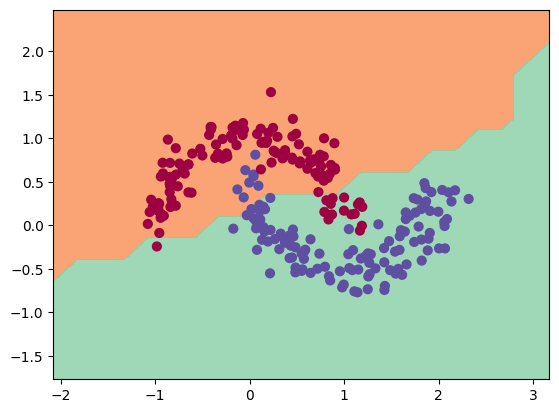

In [14]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = list(map(Tensor, Xmesh))
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())